# Depth prediction

## Read images from preprocessed file

See [read_kitti.py](read_kitti.py)

In [1]:
train_files = ["kitti/train.txt"]
test_files = ["kitti/test.txt"]

## Augmentation for a pair images

In [2]:
import tensorflow as tf


def preprocess_test_images(left_image, right_image, name="preprocess"):
    with tf.variable_scope(name, reuse=True):
        # randomly flip images
        should_flip = tf.random_uniform([], 0, 1)
        left_image, right_image = tf.cond(
            tf.greater(should_flip, 0.5), 
            lambda: [tf.image.flip_left_right(right_image), tf.image.flip_left_right(left_image)], 
            lambda: [left_image, right_image])

        # randomly augment images
        should_augment = tf.Variable(tf.random_uniform([], 0, 1), trainable=False)
        left_image, right_image = tf.cond(tf.greater(should_augment, 0.5), lambda: augment(left_image, right_image), lambda: (left_image, right_image))

        left_image.set_shape([None, None, 3])
        right_image.set_shape([None, None, 3])

        return left_image, right_image

    
def augment(left_image, right_image):
    # shift gamma
    random_gamma = tf.random_uniform([], 0.8, 1.2)
    left_image_aug = left_image ** random_gamma
    right_image_aug = right_image ** random_gamma

    # shift brightness
    random_brightness = tf.random_uniform([], 0.5, 2.0)
    left_image_aug = left_image_aug * random_brightness
    right_image_aug = right_image_aug * random_brightness

    # shift color
    random_colors = tf.random_uniform([3], 0.8, 1.2)
    shape = tf.shape(left_image)
    white = tf.ones([shape[0], shape[1]])
    color_mask = tf.stack([white * random_colors[i] for i in range(3)], axis=2)
    left_image_aug *= color_mask
    right_image_aug *= color_mask

    # normalize
    left_image_aug = tf.clip_by_value(left_image_aug,  0, 1)
    right_image_aug = tf.clip_by_value(right_image_aug, 0, 1)
    
    return left_image_aug, right_image_aug

## Create generator with tf to prevent loading images to the memory

In [3]:
def read_images(files, input_width=512, input_height=512, batch_size=32):
    input_queue = tf.train.string_input_producer(files, shuffle=False)
    reader = tf.TextLineReader()
    _, path = reader.read(input_queue)
    
    splits = tf.string_split([path], ";").values
    left_image  = tf.image.convert_image_dtype(tf.image.decode_jpeg(tf.read_file(splits[0])), tf.float32)
    right_image = tf.image.convert_image_dtype(tf.image.decode_jpeg(tf.read_file(splits[1])), tf.float32)

    left_image  = tf.image.resize_images(left_image,  [input_height, input_width], tf.image.ResizeMethod.AREA)
    right_image = tf.image.resize_images(right_image, [input_height, input_width], tf.image.ResizeMethod.AREA)

    return tf.train.shuffle_batch(
        preprocess_test_images(left_image, right_image),
        batch_size, 
        128 + 4 * batch_size, 
        128,
        4,
        allow_smaller_final_batch=True)

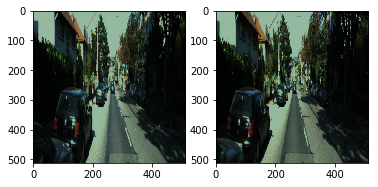

In [4]:
from matplotlib import pyplot as plt

%matplotlib inline

train_files = tf.convert_to_tensor(train_files, dtype=tf.string)
test_files = tf.convert_to_tensor(test_files, dtype=tf.string)
batch_x, batch_y = read_images(train_files)

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    coordinator = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coordinator)
        
    x1, y1 = sess.run([batch_x, batch_y])
    fig = plt.figure()
    sp = fig.add_subplot(1, 2, 1)
    sp.imshow(x1[0])
    sp = fig.add_subplot(1, 2, 2)
    sp.imshow(y1[0])
    
    coordinator.request_stop()
    coordinator.join(threads)

## Setup loss operation and training parameters

In [5]:
from model import *

rate = 1e-4

EPOCHS = 50

batch_x.get_shape().as_list()
outputs, outputs_left, outputs_right = model(batch_x)
print(outputs)
print()
print(outputs_left)
print()

[None, 256, 256, 32]
[None, 128, 128, 64]
[None, 64, 64, 128]
[None, 32, 32, 256]
[None, 16, 16, 512]
[None, 8, 8, 512]
[None, 4, 4, 512]
[None, 8, 8, 512]
[None, 16, 16, 512]
[None, 32, 32, 256]
[None, 64, 64, 128]
[None, 128, 128, 64]
[None, 256, 256, 32]
[None, 512, 512, 16]
[<tf.Tensor 'model/mul_3:0' shape=(?, 512, 512, 2) dtype=float32>, <tf.Tensor 'model/ResizeNearestNeighbor_2:0' shape=(?, 512, 512, 2) dtype=float32>, <tf.Tensor 'model/ResizeNearestNeighbor_1:0' shape=(?, 256, 256, 2) dtype=float32>, <tf.Tensor 'model/ResizeNearestNeighbor:0' shape=(?, 128, 128, 2) dtype=float32>]

[<tf.Tensor 'model/ExpandDims:0' shape=(?, 512, 512, 1) dtype=float32>, <tf.Tensor 'model/ExpandDims_1:0' shape=(?, 512, 512, 1) dtype=float32>, <tf.Tensor 'model/ExpandDims_2:0' shape=(?, 256, 256, 1) dtype=float32>, <tf.Tensor 'model/ExpandDims_3:0' shape=(?, 128, 128, 1) dtype=float32>]



In [6]:
saver = tf.train.Saver()

loss = loss(outputs_left, outputs_right, batch_x, batch_y)

[<tf.Tensor 'model/ExpandDims:0' shape=(?, 512, 512, 1) dtype=float32>, <tf.Tensor 'model/ExpandDims_1:0' shape=(?, 512, 512, 1) dtype=float32>, <tf.Tensor 'model/ExpandDims_2:0' shape=(?, 256, 256, 1) dtype=float32>, <tf.Tensor 'model/ExpandDims_3:0' shape=(?, 128, 128, 1) dtype=float32>]

[<tf.Tensor 'sub:0' shape=(?, 512, 511, 1) dtype=float32>, <tf.Tensor 'sub_1:0' shape=(?, 512, 511, 1) dtype=float32>, <tf.Tensor 'sub_2:0' shape=(?, 256, 255, 1) dtype=float32>, <tf.Tensor 'sub_3:0' shape=(?, 128, 127, 1) dtype=float32>]

[<tf.Tensor 'shuffle_batch:0' shape=(?, 512, 512, 3) dtype=float32>, <tf.Tensor 'ResizeArea_2:0' shape=(?, 256, 256, 3) dtype=float32>, <tf.Tensor 'ResizeArea_3:0' shape=(?, 128, 128, 3) dtype=float32>, <tf.Tensor 'ResizeArea_4:0' shape=(?, 64, 64, 3) dtype=float32>]

[<tf.Tensor 'sub_8:0' shape=(?, 512, 511, 3) dtype=float32>, <tf.Tensor 'sub_9:0' shape=(?, 256, 255, 3) dtype=float32>, <tf.Tensor 'sub_10:0' shape=(?, 128, 127, 3) dtype=float32>, <tf.Tensor 'sub_1

ValueError: Dimensions must be equal, but are 512 and 256 for 'mul_1' (op: 'Mul') with input shapes: [?,512,511,1], [?,256,255,1].

In [ ]:
from datetime import datetime

def train(output_node, restore=False):
    loss_operation = get_loss_operation(output_node)
    training_operation = optimizer.minimize(loss_operation)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        if restore:
            saver.restore(sess, tf.train.latest_checkpoint('.'))

        num_elements = len(X_train)
        output_shape = output_node.get_shape().as_list()
        gen = batch_generator(X_train, y_train, batch_size=BATCH_SIZE, output_shape=(output_shape[2], output_shape[1]))
        plot_gen = batch_generator(np.array([X_valid[0]]), np.array([y_valid[0]]), batch_size=1, output_shape=(output_shape[2], output_shape[1]))
        plot_img, plot_depth = next(plot_gen)
        
        valid_loss_list = []
        train_loss_list = []
        
        best_loss = float("inf")

        for i in range(0, EPOCHS):
            epoch_begin = datetime.now()
            print("Epoch {}...".format(i + 1))

            training_loss = 0
            for offset in range(0, num_elements, BATCH_SIZE):
                batch_begin = datetime.now()
                batch_x, batch_y = next(gen)
                _, loss = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
                training_loss += loss
                print("{} / {} [{}s]".format(min([offset + BATCH_SIZE, num_elements]), num_elements, (datetime.now() - batch_begin).total_seconds()))
             
            valid_loss = evaluate(X_valid, y_valid, loss_operation, (output_shape[2], output_shape[1]))
            valid_loss_list.append(valid_loss)
            train_loss_list.append(training_loss)
            img = sess.run(output_node, feed_dict = {x: plot_img, y: plot_depth, keep_prob: 1})

            clear_output(wait=True)

            plt.close("all")

            sp = plt.subplot2grid((2, 3), (0, 0), colspan=3)
            sp.plot(
                range(0, len(valid_loss_list)), valid_loss_list, 
                range(0, len(train_loss_list)), train_loss_list, "r--")
            sp = plt.subplot2grid((2, 3), (1, 0))
            sp.imshow(cv2.cvtColor(plot_img[0], cv2.COLOR_YUV2BGR))
            sp = plt.subplot2grid((2, 3), (1, 1))
            sp.imshow(plot_depth[0, :, :, 0], cmap='viridis')
            sp = plt.subplot2grid((2, 3), (1, 2))
            sp.imshow(img[0, :, :, 0], cmap='viridis')
            

            display(plt.gcf())

            print("Epoch {}.".format(i + 1))
            print("Loss: {}.\nCompleted in {}s".format(loss, (datetime.now() - epoch_begin).total_seconds()))

            if best_loss > loss:
                best_loss = loss
                print("Best loss achieved. Saving model to {}".format("model-" + output_node.name.split('/')[0]))
                saver.save(sess, './model-' + output_node.name.split('/')[0])
                
            print()
            print()

In [ ]:
train(reshaped)

In [ ]:
reshaped = tf.stop_gradient(reshaped)
train(fine3, restore=True)

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    gen = batch_generator(images, depths, batch_size=1)
    X, Y = next(gen)
    img = sess.run(tf.exp(reshaped), feed_dict={x: X, y: Y, keep_prob: 1.0})
    
    print(img.shape)
    
    fig = plt.figure()
    fig.set_figheight(50)
    fig.set_figwidth(50)
    sp = fig.add_subplot(1, 3, 1)
    sp.imshow(cv2.cvtColor(X[0], cv2.COLOR_YUV2BGR))
    sp = fig.add_subplot(1, 3, 2)
    sp.imshow(Y[0, :, :, 0], cmap='hot')
    sp = fig.add_subplot(1, 3, 3)
    sp.imshow(img[0, :, :, 0], cmap='hot')